In [1]:
import h5py
from tqdm.notebook import tqdm
import scipy
import torch
from torch_geometric.data import Data
import os

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import illustris_python as il

from sklearn.ensemble import RandomForestRegressor

ROOT = Path("..").resolve().parent
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"


# Get cosmic web params

In [2]:
cw = h5py.File(f"{ROOT}/illustris_data/TNG300-1/postprocessing/disperse/disperse_099.hdf5")
cw.keys()

<KeysViewHDF5 ['d_minima', 'd_node', 'd_saddle_1', 'd_saddle_2', 'd_skel', 'subhalo_ID']>

In [3]:
cw = pd.DataFrame(
    {k: cw[k] for k in cw.keys()}
).rename({"subhalo_ID": "subhalo_id"}, axis=1).set_index("subhalo_id")

# normalize
cw = (cw - cw.mean(0)) / cw.std(0)

cw.head()

,d_minima,d_node,d_saddle_1,d_saddle_2,d_skel
subhalo_id,,,,,
0,-0.405779,-1.471773,-1.259529,-1.104576,-1.163798
1,-0.671898,-1.505375,-0.801792,-0.777483,-1.195676
2,-0.488557,-1.194772,-1.493097,-1.245941,-1.161969
3,-0.488640,-0.783244,-1.150201,-1.423575,-1.180119
4,-0.490822,-1.132100,-1.446336,-1.392441,-1.150521


# Make PyG dataset

In [5]:
snapshot=99
r_link=5
pad=2.5
split=6
use_gal=False
h=0.6774
undirected=True 
periodic=False 
use_loops=True
in_projection=False
train_test_frac_split = split**2

cuts = {
    "minimum_log_stellar_mass": 9,
    "minimum_log_halo_mass": 10,
    "minimum_n_star_particles": 50
}

config_params = dict(
    boxsize=51.7e3,    # box size in comoving kpc/h
    h_reduced=0.704,   # reduced Hubble constant
    snapshot=99,       # z = 0
)

normalization_params = dict(
    minimum_n_star_particles=10., # min star particles to be considered a galaxy
    norm_half_mass_radius=8., 
    norm_velocity=100., # note: use value of 1 if `use_central_galaxy_frame=True`
)

In [6]:
use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_loghalomass', 'subhalo_logvmax'] 
y_cols = ['subhalo_logstellarmass']

subhalo_fields = [
    "SubhaloPos", "SubhaloMassType", "SubhaloLenType", "SubhaloHalfmassRadType", 
    "SubhaloVel", "SubhaloVmax", "SubhaloGrNr", "SubhaloFlag"
]
subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

pos = subhalos["SubhaloPos"][:,:3]
min_box, max_box = np.rint(np.min(pos)), np.rint(np.max(pos))
box_size = max_box/(h*1e3) # in Mpc

halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
halos = il.groupcat.loadHalos(tng_base_path, snapshot, fields=halo_fields)

subhalo_pos = subhalos["SubhaloPos"][:] / (h*1e3)
subhalo_stellarmass = subhalos["SubhaloMassType"][:,4]
subhalo_halomass = subhalos["SubhaloMassType"][:,1]
subhalo_n_stellar_particles = subhalos["SubhaloLenType"][:,4]
subhalo_stellarhalfmassradius = subhalos["SubhaloHalfmassRadType"][:,4]  / normalization_params["norm_half_mass_radius"]
subhalo_vel = subhalos["SubhaloVel"][:] /  normalization_params["norm_velocity"]
subhalo_vmax = subhalos["SubhaloVmax"][:] / normalization_params["norm_velocity"]
subhalo_flag = subhalos["SubhaloFlag"][:]
halo_id = subhalos["SubhaloGrNr"][:].astype(int)

halo_mass = halos["Group_M_Crit200"][:]
halo_primarysubhalo = halos["GroupFirstSub"][:].astype(int)
group_pos = halos["GroupPos"][:] / (h*1e3)
group_vel = halos["GroupVel"][:]  / normalization_params["norm_velocity"]

halos = pd.DataFrame(
    np.column_stack((np.arange(len(halo_mass)), group_pos, group_vel, halo_mass, halo_primarysubhalo)),
    columns=['halo_id', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mass', 'halo_primarysubhalo']
)
halos['halo_id'] = halos['halo_id'].astype(int)
halos.set_index("halo_id", inplace=True)

# get subhalos/galaxies      
subhalos = pd.DataFrame(
    np.column_stack([halo_id, subhalo_flag, np.arange(len(subhalo_stellarmass)), subhalo_pos, subhalo_vel, subhalo_n_stellar_particles, subhalo_stellarmass, subhalo_halomass, subhalo_stellarhalfmassradius, subhalo_vmax]), 
    columns=['halo_id', 'subhalo_flag', 'subhalo_id', 'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass', 'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax'],
)
subhalos["is_central"] = (halos.loc[subhalos.halo_id]["halo_primarysubhalo"].values == subhalos["subhalo_id"].values)

subhalos = subhalos[subhalos["subhalo_flag"] != 0].copy()
subhalos['halo_id'] = subhalos['halo_id'].astype(int)
subhalos['subhalo_id'] = subhalos['subhalo_id'].astype(int)

subhalos.drop("subhalo_flag", axis=1, inplace=True)

# impose stellar mass and particle cuts
subhalos = subhalos[subhalos["subhalo_n_stellar_particles"] > cuts["minimum_n_star_particles"]].copy()
subhalos["subhalo_logstellarmass"] = np.log10(subhalos["subhalo_stellarmass"] / h)+10

subhalos["subhalo_loghalomass"] = np.log10(subhalos["subhalo_halomass"] / h)+10
subhalos["subhalo_logvmax"] = np.log10(subhalos["subhalo_vmax"])
subhalos["subhalo_logstellarhalfmassradius"] = np.log10(subhalos["subhalo_stellarhalfmassradius"])

subhalos = subhalos[subhalos["subhalo_loghalomass"] > cuts["minimum_log_halo_mass"]].copy()

subhalos = subhalos[subhalos["subhalo_logstellarmass"] > cuts["minimum_log_stellar_mass"]].copy()


/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
subhalos = subhalos.join(cw, on="subhalo_id", how="left")

In [24]:
data_path = f"{ROOT}/illustris_data/TNG300-1/postprocessing/pyg_data_disperse.h5"
data = []
for n in tqdm(range(split), position=0):
    for g in tqdm(range(split), position=1, leave=False):
        for k in tqdm(range(split), position=2, leave=False):
            # print(n,g,k)
            xlims = np.array([box_size/split*n+pad, box_size/split*(n+1)-pad])
            ylims = np.array([box_size/split*g+pad, box_size/split*(g+1)-pad])
            zlims = np.array([box_size/split*k+pad, box_size/split*(k+1)-pad])

            pos = np.vstack(subhalos[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

            xmask = np.logical_and(pos[:,0]>xlims[0],pos[:,0]<xlims[1])
            ymask = np.logical_and(pos[:,1]>ylims[0],pos[:,1]<ylims[1])
            zmask = np.logical_and(pos[:,2]>zlims[0],pos[:,2]<zlims[1])
            mask = np.logical_and(zmask, np.logical_and(xmask, ymask))

            df = subhalos.iloc[mask].copy()
            df.reset_index(drop=True)

            # remove extraneous columns
            df.drop(["subhalo_n_stellar_particles", "subhalo_stellarmass", "subhalo_halomass"], axis=1, inplace=True)

            # set new zero point

            df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']] - np.array([box_size/split*n+pad, box_size/split*g+pad, box_size/split*k+pad])

            #make positions for clustering

            if in_projection:
                pos = np.vstack(df[['subhalo_x', 'subhalo_y']].to_numpy())    
            else:
                pos = np.vstack(df[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

            kd_tree = scipy.spatial.KDTree(pos, leafsize=25, boxsize=box_size)
            edge_index = kd_tree.query_pairs(r=r_link, output_type="ndarray")

            # normalize positions

            df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']]/(box_size/2)

            if undirected:
            # Add reverse pairs
                reversepairs = np.zeros((edge_index.shape[0],2))
                for i, pair in enumerate(edge_index):
                    reversepairs[i] = np.array([pair[1], pair[0]])
                edge_index = np.append(edge_index, reversepairs, 0)

                edge_index = edge_index.astype(int)

                # Write in pytorch-geometric format
                edge_index = edge_index.reshape((2,-1))
                num_pairs = edge_index.shape[1]

            row, col = edge_index

            diff = pos[row]-pos[col]
            dist = np.linalg.norm(diff, axis=1)

            use_gal = True

            if periodic:
                # Take into account periodic boundary conditions, correcting the distances
                for i, pos_i in enumerate(diff):
                    for j, coord in enumerate(pos_i):
                        if coord > r_link:
                            diff[i,j] -= box_size  # Boxsize normalize to 1
                        elif -coord > r_link:
                            diff[i,j] += box_size  # Boxsize normalize to 1

            centroid = np.mean(pos,axis=0) # define arbitrary coordinate, invarinat to translation/rotation shifts, but not stretches
            # centroid+=1.2

            unitrow = (pos[row]-centroid)/np.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
            unitcol = (pos[col]-centroid)/np.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
            unitdiff = diff/dist.reshape(-1,1)
            # Dot products between unit vectors
            cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
            cos2 = np.array([np.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])

            edge_attr = np.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)

            if use_loops:
                loops = np.zeros((2,pos.shape[0]),dtype=int)
                atrloops = np.zeros((pos.shape[0], edge_attr.shape[1]))
                for i, posit in enumerate(pos):
                    loops[0,i], loops[1,i] = i, i
                    atrloops[i,0], atrloops[i,1], atrloops[i,2] = 0., 1., 0.
                edge_index = np.append(edge_index, loops, 1)
                edge_attr = np.append(edge_attr, atrloops, 0)
            edge_index = edge_index.astype(int)

            x = torch.tensor(np.vstack(df[use_cols].to_numpy()), dtype=torch.float)
            y = torch.tensor(np.vstack(df[y_cols].to_numpy()), dtype=torch.float)
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            edge_attr=torch.tensor(edge_attr, dtype=torch.float)
            pos = torch.tensor(pos, dtype=torch.float)
            is_central = torch.tensor(df.is_central.values, dtype=bool)
            overdensity = torch.zeros(len(x), dtype=x.dtype)
            for i in range(len(x)):
                neighbors = edge_index[1, edge_index[0] == i] # get neighbor indices
                overdensity[i] = torch.log10((10**x[neighbors, -2]).sum()) # get sum of masses of neighbors (2nd to last index in `x`)

            cosmic_web = torch.tensor(np.vstack(df[["d_minima", "d_node", "d_saddle_1", "d_saddle_2", "d_skel"]].to_numpy()), dtype=torch.float)

            data.append(Data(x=x, y=y, pos=pos, is_central=is_central, edge_index=edge_index, edge_attr=edge_attr, overdensity=overdensity, cosmic_web=cosmic_web))

            proj_str = "-projected" if in_projection else ""

            if not os.path.isdir(os.path.join(tng_base_path, 'cosmic_graphs')):
                os.mkdir(os.path.join(tng_base_path, 'cosmic_graphs'))

            with open(data_path, 'wb') as handle:
                pickle.dump(data, handle)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Train random forest

In [26]:
data_path = f"{ROOT}/illustris_data/TNG300-1/postprocessing/pyg_data_disperse.h5"
data = pickle.load(open(data_path, 'rb'))

In [29]:
def train_validate_disperse(data, k, split=6):
    """Here data should just be subhalo catalog joined with disperse catalog"""
    
    data_train = data[:k*train_test_frac_split] + data[(k+1)*train_test_frac_split:]
    data_valid = data[k*train_test_frac_split:(k+1)*train_test_frac_split]

    X_train_disperse = np.concatenate([torch.hstack([d.x[:, -2:], d.cosmic_web[:, :]]) for d in data_train], 0)
    y_train = np.concatenate([d.y[:, 0] for d in data_train])
    X_valid_disperse = np.concatenate([torch.hstack([d.x[:, -2:], d.cosmic_web[:, :]]) for d in data_valid], 0)
    y_valid = np.concatenate([d.y[:, 0] for d in data_valid])

    rf_disperse = RandomForestRegressor()
    rf_disperse.fit(X_train_disperse, y_train)

    p_log_Mhalo_rf_disperse = rf_disperse.predict(X_valid_disperse)

    return pd.DataFrame({
        "p_RF_disperse": p_log_Mhalo_rf_disperse, 
        "log_Mstar": y_valid,
    })

In [44]:
for k in range(6):
    df_disperse_k = train_validate_disperse(data, k)
    df_disperse_k.to_csv(f"{ROOT}/results/predicting-Mstar/cosmic_web_disperse/validation-fold{k+1}.csv", index=False)

# Comparison plot

In [35]:
def rmse(p, y): return ((p - y) ** 2).mean()**0.5

In [62]:
def get_rmse_kfold(k, D):
    df_3d = pd.read_csv(f"{results_dir}/r_link{D}/validation-fold{k}.csv")
    df_2d = pd.read_csv(f"{results_dir}/r_link{D}/validation-projected-fold{k}.csv")
    df_cw = pd.read_csv(f"{ROOT}/results/predicting-Mstar/cosmic_web_disperse/validation-fold{k}.csv")
    return (
        rmse(df_3d["p_GNN_3d"], df_3d["log_Mstar"]), 
        rmse(df_2d["p_GNN_2d"], df_2d["log_Mstar"]),
        rmse(df_3d["p_RF_overdensity"], df_3d["log_Mstar"]),
        rmse(df_cw["p_RF_disperse"], df_cw["log_Mstar"])
    )


In [63]:
loops = 1
aggr = "multi"
results_dir = f"{ROOT}/results/predicting-Mstar/gnns-upgraded_{aggr}_loops-{loops}"
D_links = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7.5, 10]     

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'



In [84]:
np.array(rmse_3d)

array([[0.15025877, 0.15537752, 0.14990561, 0.14666092, 0.14686628,
        0.15434769],
       [0.13276667, 0.13772784, 0.13345578, 0.13624553, 0.13438572,
        0.13491022],
       [0.13018595, 0.13267728, 0.13327135, 0.13188476, 0.13094744,
        0.12867222],
       [0.1275014 , 0.13286246, 0.13363496, 0.13848827, 0.12916811,
        0.1306816 ],
       [0.12767722, 0.1323929 , 0.12892087, 0.12900071, 0.13222936,
        0.13296332],
       [0.12990473, 0.13361919, 0.1306108 , 0.13023545, 0.12817329,
        0.12897371],
       [0.13220216, 0.13136683, 0.13018967, 0.12956954, 0.12928997,
        0.12880722],
       [0.12843236, 0.13481178, 0.13219756, 0.13032231, 0.12844805,
        0.12933396],
       [0.1307764 , 0.13141923, 0.13201381, 0.13108718, 0.13435449,
        0.12839657],
       [0.13020221, 0.13495629, 0.13542966, 0.12969421, 0.13956644,
        0.13283149],
       [0.13892145, 0.1333484 , 0.13676564, 0.13849657, 0.13098946,
        0.13036985],
       [0.13509581, 0

3 0.1302375646812289 0.007566594316381739


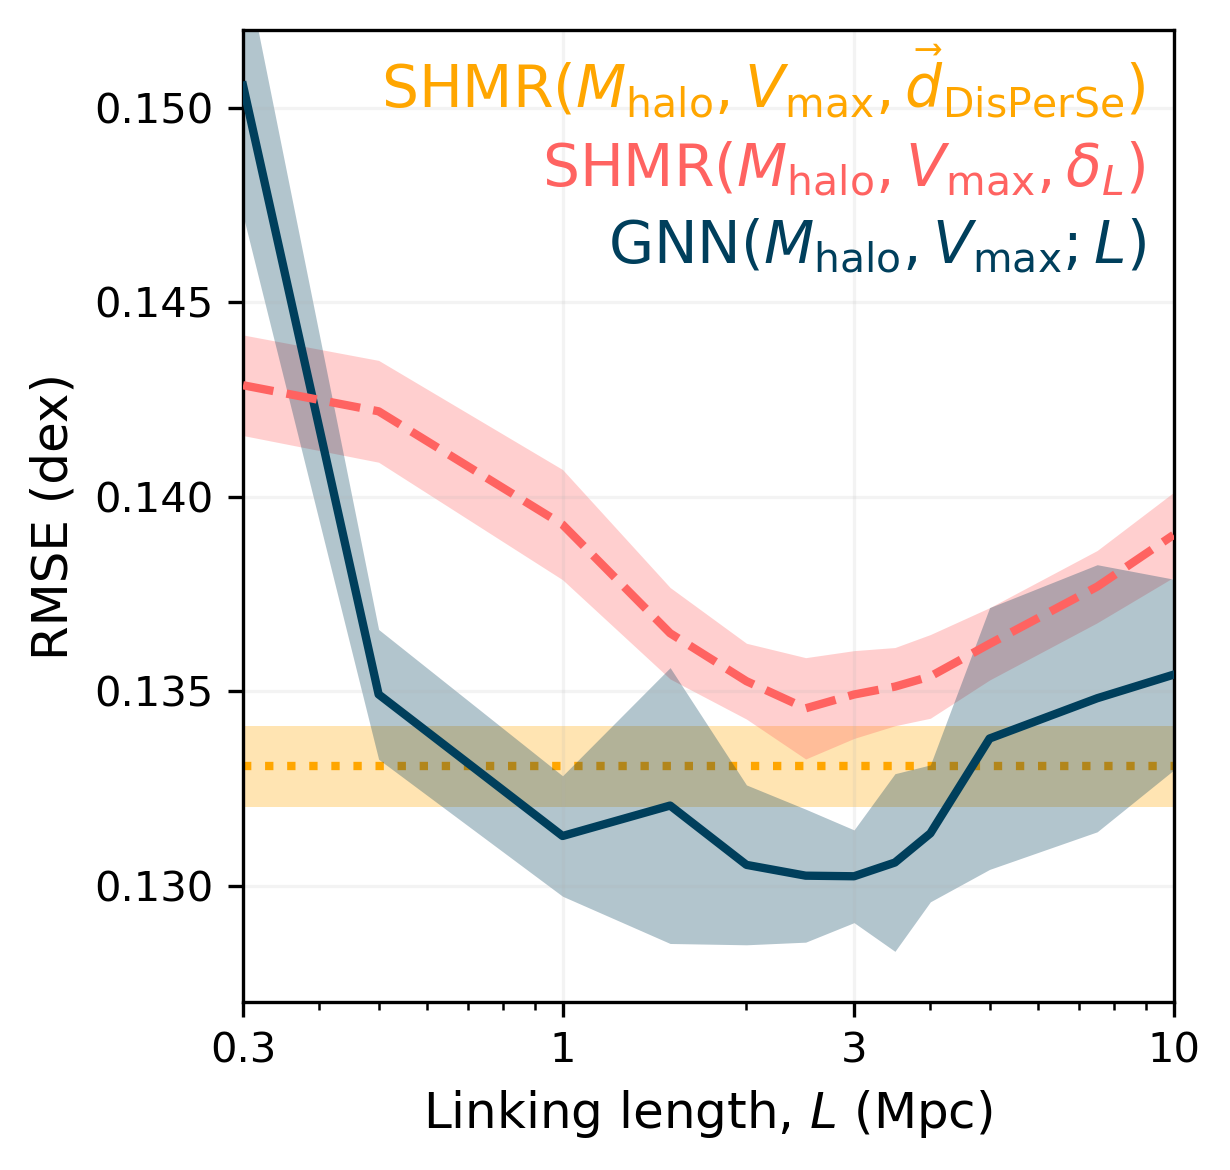

In [64]:
plt.figure(figsize=(4.2, 4.), dpi=300)

rmse_3d, rmse_2d, rmse_overdensity  = [], [], []

for D in D_links:
    res_k = np.array(list(get_rmse_kfold(k, D) for k in range(1,7))).T
    rmse_3d.append(res_k[0])
    rmse_2d.append(res_k[1])
    rmse_overdensity.append(res_k[2])

rmse_cw = res_k[3]

plt.axhline(np.mean(rmse_cw), c=c4, lw=2, ls=":", zorder=1)
plt.axhspan(np.mean(rmse_cw)-np.std(rmse_cw), np.mean(rmse_cw)+np.std(rmse_cw), color=c4, lw=0, alpha=0.3, zorder=1)

plt.plot(D_links, np.mean(rmse_overdensity, 1), c=c3, lw=2, ls="--", zorder=4)
plt.fill_between(D_links, np.mean(rmse_overdensity, 1)-np.std(rmse_overdensity, 1), np.mean(rmse_overdensity, 1)+np.std(rmse_overdensity, 1), color=c3, alpha=0.3, lw=0)

# plt.plot(D_links, np.mean(rmse_2d, 1), c=c3, lw=2, zorder=2)
# plt.fill_between(D_links, np.mean(rmse_2d, 1)-np.std(rmse_2d, 1), np.mean(rmse_2d, 1)+np.std(rmse_2d, 1), color=c3, alpha=0.3, lw=0)

plt.plot(D_links, np.mean(rmse_3d, 1), c=c0, lw=2, zorder=3)
plt.fill_between(D_links, np.mean(rmse_3d, 1)-np.std(rmse_3d, 1), np.mean(rmse_3d, 1)+np.std(rmse_3d, 1), color=c0, alpha=0.3, lw=0)

plt.text(0.97, 0.92, "SHMR($M_{\\rm halo},V_{\\rm max},\\vec{d}_{\\rm DisPerSe}$)", ha="right", transform=plt.gca().transAxes, fontsize=14, color=c4)
plt.text(0.97, 0.84, "SHMR($M_{\\rm halo},V_{\\rm max},\\delta_L$)", ha="right", transform=plt.gca().transAxes, fontsize=14, color=c3)
plt.text(0.97, 0.76, "GNN($M_{\\rm halo},V_{\\rm max};L$)", ha="right", transform=plt.gca().transAxes, fontsize=14, color=c0)

# plt.legend(loc="upper right", framealpha=0, fontsize=12, markerfirst=False)
plt.xscale("log")
plt.xticks(ticks=[0.3, 1, 3, 10], labels=[0.3, 1, 3, 10])
plt.grid(alpha=0.15)
plt.xlabel("Linking length, $L$ (Mpc)", fontsize=12)
plt.ylabel("RMSE (dex)", fontsize=12)
plt.ylim(0.127, 0.152)
plt.xlim(0.3, 10)
plt.tight_layout()
plt.savefig(f"{results_dir}/GNN_cosmic_web.pdf")

In [88]:
best_ind_gnn_3d = np.argmin(np.mean(rmse_3d, 1))
print("GNN 3d:", D_links[best_ind_rmse_3d], np.array(rmse_3d)[best_ind_gnn_3d].mean(), np.array(rmse_3d)[:best_ind_gnn_3d].std())

best_ind_gnn_2d = np.argmin(np.mean(rmse_2d, 1))
print("GNN 2d:", D_links[best_ind_gnn_2d], np.array(rmse_2d)[best_ind_gnn_2d].mean(), np.array(rmse_2d)[:best_ind_gnn_2d].std())

print("DisPerSe:", "--", np.mean(rmse_cw), np.std(rmse_cw))

best_ind_overdensity = np.argmin(np.mean(rmse_overdensity, 1))
print("Overdensity:", D_links[best_ind_overdensity], np.array(rmse_overdensity)[best_ind_overdensity].mean(), np.array(rmse_overdensity)[:best_ind_overdensity].std())


GNN 3d: 3 0.1302375646812289 0.007566594316381739
GNN 2d: 1.5 0.1322263815678453 0.00584753025168453
DisPerSe: -- 0.13306728946900218 0.001039368677744676
Overdensity: 2.5 0.1345562966286135 0.0032574629536644807
